In [22]:
import argparse
import os
import random
from typing import Any

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from lib import train_network
from scipy.optimize import bisect
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler


activation_fun_mean = torch.tanh
activation_fun_std = torch.tanh
loss_fun = nn.MSELoss

class CL_dataLoader:
    def __init__(self, original_data_path=None, configs=None):
        if original_data_path:
            self.data_dir = original_data_path
        if configs:
            self.configs = configs

    def load(self):
        X = np.load(os.path.join(self.data_dir, "x.npy")).reshape(-1, 1)
        Y = np.load(os.path.join(self.data_dir, "y.npy")).reshape(-1, 1)
        return X, Y

    def getNumInputsOutputs(self, inputsOutputs_np):
        if len(inputsOutputs_np.shape) == 1:
            numInputsOutputs = 1
        if len(inputsOutputs_np.shape) > 1:
            numInputsOutputs = inputsOutputs_np.shape[1]
        return numInputsOutputs


def caps_calculation(network_preds: dict[str, Any], c_up, c_down, Y, verbose=0):
    """Caps calculations for single quantile"""

    if verbose > 0:
        print("--- Start caps calculations for SINGLE quantile ---")
        print("**************** For Training data *****************")

    if len(Y.shape) == 2:
        Y = Y.flatten()

    bound_up = (network_preds["mean"] + c_up * network_preds["up"]).numpy().flatten()
    bound_down = (
        (network_preds["mean"] - c_down * network_preds["down"]).numpy().flatten()
    )

    y_U_cap = bound_up > Y  # y_U_cap
    y_L_cap = bound_down < Y  # y_L_cap

    y_all_cap = np.logical_or(y_U_cap, y_L_cap)  # y_all_cap
    PICP = np.count_nonzero(y_all_cap) / y_L_cap.shape[0]  # 0-1
    MPIW = np.mean(
        (network_preds["mean"] + c_up * network_preds["up"]).numpy().flatten()
        - (network_preds["mean"] - c_down * network_preds["down"]).numpy().flatten()
    )
    if verbose > 0:
        print(f"Num of train in y_U_cap: {np.count_nonzero(y_U_cap)}")
        print(f"Num of train in y_L_cap: {np.count_nonzero(y_L_cap)}")
        print(f"Num of train in y_all_cap: {np.count_nonzero(y_all_cap)}")
        print(f"np.sum results(train): {np.sum(y_all_cap)}")
        print(f"PICP: {PICP}")
        print(f"MPIW: {MPIW}")

    return (
        PICP,
        MPIW,
    )


def optimize_bound(
    *,
    mode: str,
    y_train: np.ndarray,
    pred_mean: np.ndarray,
    pred_std: np.ndarray,
    num_outliers: int,
    c0: float = 0.0,
    c1: float = 1e5,
    maxiter: int = 1000,
    verbose=0,
):
    def count_exceeding_upper_bound(c: float):
        bound = pred_mean + c * pred_std
        f = np.count_nonzero(y_train >= bound) - num_outliers
        return f

    def count_exceeding_lower_bound(c: float):
        bound = pred_mean - c * pred_std
        f = np.count_nonzero(y_train <= bound) - num_outliers
        return f

    objective_function = (
        count_exceeding_upper_bound if mode == "up" else count_exceeding_lower_bound
    )

    if verbose > 0:
        print(f"Initial bounds: [{c0}, {c1}]")

    try:
        optimal_c = bisect(objective_function, c0, c1, maxiter=maxiter)
        if verbose > 0:
            final_count = objective_function(optimal_c)
            print(f"Optimal c: {optimal_c}, Final count: {final_count}")
        return optimal_c
    except ValueError as e:
        if verbose > 0:
            print(f"Bisect method failed: {e}")
        raise e


def compute_boundary_factors(
    *, y_train: np.ndarray, network_preds: dict[str, Any], quantile: float, verbose=0
) -> tuple[float, float]:
    n_train = y_train.shape[0]
    num_outlier = int(n_train * (1 - quantile) / 2)

    if verbose > 0:
        print(
            "--- Start boundary optimizations for SINGLE quantile: {}".format(quantile)
        )
        print(
            "--- Number of outlier based on the defined quantile: {}".format(
                num_outlier
            )
        )

    c_up, c_down = [
        optimize_bound(
            y_train=y_train,
            pred_mean=network_preds["mean"],
            pred_std=network_preds[mode],
            mode=mode,
            num_outliers=num_outlier,
        )
        for mode in ["up", "down"]
    ]

    if verbose > 0:
        print("--- c_up: {}".format(c_up))
        print("--- c_down: {}".format(c_down))

    return c_up, c_down


def create_PI_training_data(
    network_mean, X, Y
) -> tuple[tuple[torch.Tensor, torch.Tensor], tuple[torch.Tensor, torch.Tensor]]:
    """Generate up and down training data by splitting at the median."""
    with torch.no_grad():
        diff_train = Y.reshape(Y.shape[0], -1) - network_mean(X)
        diff_train -= torch.median(diff_train)  # make sure same amount of up and down
        up_idx = diff_train > 0
        down_idx = diff_train < 0

        X_up = X[up_idx.flatten()]
        Y_up = diff_train[up_idx].unsqueeze(1)

        X_down = X[down_idx.flatten()]
        Y_down = -1.0 * diff_train[down_idx].unsqueeze(1)

    # check that number there is at most one more sample in up/down
    # this property should hold since we split at the median
    # if the number of samples is even, the difference will be 0
    assert abs(X_up.shape[0] - X_down.shape[0]) <= 1, (abs(X_up.shape[0] - X_down.shape[0]), X_up.shape)

    return ((X_up, Y_up), (X_down, Y_down))


class CL_trainer:
    def __init__(
        self,
        configs,
        net_mean,
        net_up,
        net_down,
        x_train,
        y_train,
        x_valid,
        y_valid,
        x_test=None,
        y_test=None,
        lr=1e-2,
        decay_rate = 0.96,
        decay_steps = 1000,
    ):
        """Take all 3 network instance and the trainSteps (CL_UQ_Net_train_steps) instance"""

        self.configs = configs

        self.networks = {
            "mean": net_mean,
            "up": net_up,
            "down": net_down,
        }
        self.optimizers = {
            network_type: torch.optim.Adam(
                network.parameters(), lr=lr
                # network.parameters(), lr=1e-3, weight_decay=0  # good for mean, bad for stds
                # network.parameters(), lr=1e-3, weight_decay=2e-2  # too strong weight_decay
                # network.parameters(), lr=1e-3, weight_decay=2e-3  # still a bit too strong for mean, but too little for std
            )
            for network_type, network in self.networks.items()
        }

        self.schedulers = {
            network_type: torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)
            for network_type, optimizer in self.optimizers.items()
        }

        self.x_train = x_train
        self.y_train = y_train
        self.x_valid = x_valid
        self.y_valid = y_valid
        self.x_test = x_test
        self.y_test = y_test

    def train(self):
        print("Training MEAN Network")
        train_network(
            model=self.networks["mean"],
            optimizer=self.optimizers["mean"],
            scheduler=self.schedulers["mean"],
            criterion=loss_fun(),
            train_loader=[(self.x_train, self.y_train)],
            val_loader=[(self.x_valid, self.y_valid)],
            max_epochs=self.configs["Max_iter"],
        )

        data_train_up, data_train_down = create_PI_training_data(
            self.networks["mean"], X=self.x_train, Y=self.y_train
        )
        data_val_up, data_val_down = create_PI_training_data(
            self.networks["mean"], X=self.x_valid, Y=self.y_valid
        )

        print("Training UP Network")
        train_network(
            model=self.networks["up"],
            optimizer=self.optimizers["up"],
            scheduler=self.schedulers["up"],
            criterion=loss_fun(),
            train_loader=[data_train_up],
            val_loader=[data_val_up],
            max_epochs=self.configs["Max_iter"],
        )
        print("Training DOWN Network")
        train_network(
            model=self.networks["down"],
            optimizer=self.optimizers["down"],
            scheduler=self.schedulers["down"],
            criterion=loss_fun(),
            train_loader=[data_train_down],
            val_loader=[data_val_down],
            max_epochs=self.configs["Max_iter"],
        )

    def eval_networks(self, x, as_numpy: bool = False) -> dict[str, Any]:
        with torch.no_grad():
            d = {k: network(x) for k, network in self.networks.items()}
        if as_numpy:
            d = {k: v.numpy() for k, v in d.items()}
        return d


# TODO: Add regularization to optimizer step
# every dense layer had it: regularizers.l1_l2(l1=0.02, l2=0.02)
class UQ_Net_mean(nn.Module):
    def __init__(self, configs, num_inputs, num_outputs):
        super(UQ_Net_mean, self).__init__()
        self.configs = configs
        self.num_nodes_list = self.configs["num_neurons_mean"]

        self.inputLayer = nn.Linear(num_inputs, self.num_nodes_list[0])
        self.fcs = nn.ModuleList()
        for i in range(len(self.num_nodes_list) - 1):
            self.fcs.append(
                nn.Linear(self.num_nodes_list[i], self.num_nodes_list[i + 1])
            )
        self.outputLayer = nn.Linear(self.num_nodes_list[-1], num_outputs)

        # Initialize weights with a mean of 0.1 and stddev of 0.1
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.1, std=0.1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = activation_fun_mean(self.inputLayer(x))
        for i in range(len(self.fcs)):
            x = activation_fun_mean(self.fcs[i](x))
        x = self.outputLayer(x)
        return x


class UQ_Net_std(nn.Module):
    def __init__(self, configs, num_inputs, num_outputs, net=None, bias=None):
        super(UQ_Net_std, self).__init__()
        self.configs = configs
        if net == "up":
            self.num_nodes_list = self.configs["num_neurons_up"]
        elif net == "down":
            self.num_nodes_list = self.configs["num_neurons_down"]

        self.inputLayer = nn.Linear(num_inputs, self.num_nodes_list[0])
        self.fcs = nn.ModuleList()
        for i in range(len(self.num_nodes_list) - 1):
            self.fcs.append(
                nn.Linear(self.num_nodes_list[i], self.num_nodes_list[i + 1])
            )
        self.outputLayer = nn.Linear(self.num_nodes_list[-1], num_outputs)

        # Initialize weights with a mean of 0.1 and stddev of 0.1
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.1, std=0.1)
                nn.init.zeros_(m.bias)

        # Custom bias
        if bias is None:
            self.custom_bias = torch.nn.Parameter(torch.tensor([3.0]))
        else:
            self.custom_bias = torch.nn.Parameter(torch.tensor([bias]))

    def forward(self, x):
        x = activation_fun_std(self.inputLayer(x))
        for i in range(len(self.fcs)):
            x = activation_fun_std(self.fcs[i](x))
        x = self.outputLayer(x)
        x = x + self.custom_bias
        x = torch.sqrt(torch.square(x) + 1e-8)  # TODO: Was 0.2 but not explained why in paper
        return x

In [23]:
class Args:
    quantile = 0.9
args = Args()

##########################################################
################## Data Loading Section ##################
##########################################################
data_dir = "../data_out/3pinn/"
dataLoader = CL_dataLoader(original_data_path=data_dir)
X, Y = dataLoader.load()
# mask = X[:,0] >= 1e-2
# print(mask.shape, np.count_nonzero(mask))
# X = X[mask,:].copy()
# Y = Y[mask,:].copy()
if len(Y.shape) == 1:
    Y = Y.reshape(-1, 1)

# The first 550 points should be enough
X = X[:550].copy()
Y = Y[:550].copy()

# Y = 1 / Y
print(X.min())

2.699975431930124e-05


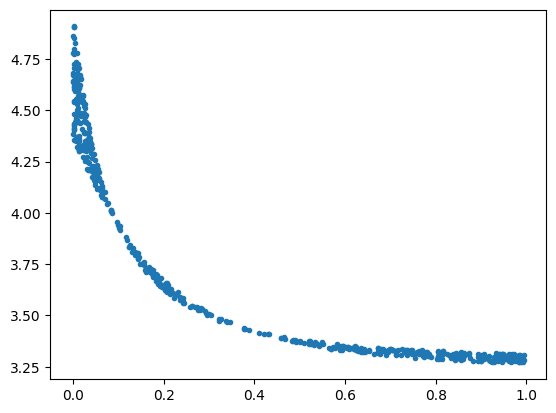

In [24]:
import matplotlib.pyplot as plt

plt.plot(X, Y, ".")
plt.show()

In [25]:
SEED = 1


# random split
xTrainValid, xTest, yTrainValid, yTest = train_test_split(
    X, Y, test_size=0.1, random_state=SEED, shuffle=True
)
## Split the validation data
xTrain, xValid, yTrain, yValid = train_test_split(
    xTrainValid, yTrainValid, test_size=0.1, random_state=SEED, shuffle=True
)

### Data normalization
scalar_x = StandardScaler()
scalar_y = StandardScaler()

xTrain = scalar_x.fit_transform(xTrain)
xValid = scalar_x.fit_transform(xValid)
xTest = scalar_x.transform(xTest)

yTrain = scalar_y.fit_transform(yTrain)
yValid = scalar_y.fit_transform(yValid)
yTest = scalar_y.transform(yTest)

### To tensors
xTrain = torch.Tensor(xTrain)
xValid = torch.Tensor(xValid)
xTest = torch.Tensor(xTest)

yTrain = torch.Tensor(yTrain)
yValid = torch.Tensor(yValid)
yTest = torch.Tensor(yTest)

print(xTrain.shape)
print(xValid.shape)
print(xTest.shape)
print(yTrain.shape)
print(yValid.shape)
print(yTest.shape)
# exit()

torch.Size([445, 1])
torch.Size([50, 1])
torch.Size([55, 1])
torch.Size([445, 1])
torch.Size([50, 1])
torch.Size([55, 1])


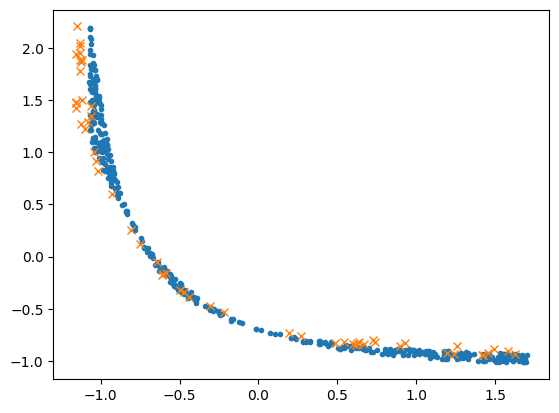

In [26]:
import matplotlib.pyplot as plt

plt.plot(xTrain, yTrain, ".")
plt.plot(xTest, yTest, "x")
# plt.plot(xValid, yValid, "d")
plt.show()

In [27]:

#########################################################
############## End of Data Loading Section ##############
#########################################################

num_inputs = dataLoader.getNumInputsOutputs(xTrain)
num_outputs = dataLoader.getNumInputsOutputs(yTrain)

configs = {}
### Some other general input info
configs["quantile"] = (
    args.quantile
)  # # target percentile for optimization step# target percentile for optimization step,
# 0.95 by default if not specified

######################################################################################
# TODO: Re-Implement this
# Multiple quantiles, comment out this line in order to run single quantile estimation
# configs['quantile_list'] = np.arange(0.05, 1.00, 0.05) # 0.05-0.95
######################################################################################

### specify hypar-parameters for the training
configs["seed"] = 34875663  # general random seed
configs["num_neurons_mean"] = [16]  # hidden layer(s) for the 'MEAN' network
configs["num_neurons_up"] = [64]  # hidden layer(s) for the 'UP' network
configs["num_neurons_down"] = [64]  # hidden layer(s) for the 'DOWN' network
configs["Max_iter"] = 5000  # 5000,
LR = 1e-2
DECAY_RATE = 0.96 # Define decay rate
DECAY_STEPS = 1000 # Define decay steps
random.seed(configs["seed"])
np.random.seed(configs["seed"])
torch.manual_seed(configs["seed"])

In [28]:

""" Create network instances"""
net_mean = UQ_Net_mean(configs, num_inputs, num_outputs)
net_up = UQ_Net_std(configs, num_inputs, num_outputs, net="up")
net_down = UQ_Net_std(configs, num_inputs, num_outputs, net="down")

# Initialize trainer and conduct training/optimizations
trainer = CL_trainer(
    configs,
    net_mean,
    net_up,
    net_down,
    x_train=xTrain,
    y_train=yTrain,
    x_valid=xValid,
    y_valid=yValid,
    x_test=xTest,
    y_test=yTest,
    lr=LR,
    decay_rate=DECAY_RATE, # Pass decay rate to trainer
    decay_steps=DECAY_STEPS # Pass decay steps to trainer
)
trainer.train()  # training for 3 networks
# previous losses without lr decay:
# 0.102, 0.103, 0.077
# with lr decay (DECAY_STEPS=1000):
# 0.107, 0.029, 0.078
# with lr decay (DECAY_STEPS=100):
# tdlr: worse
# with lr decay (DECAY_STEPS=100, LR=1e-1):
# tdlr: worse
# with lr decay (DECAY_STEPS=1000, LR=1e-3, EPOCHS=10000):
# tdlr: worse
# with lr decay (DECAY_STEPS=1000, LR=1e-2, EPOCHS=10000):
# tdlr: worse
# with lr decay (DECAY_STEPS=1000, LR=1e-2, EPOCHS=2*10**5):
# tdlr: not better

Training MEAN Network
Epoch 500, Validation Loss: 0.045263
Epoch 1000, Validation Loss: 0.058856
Epoch 1500, Validation Loss: 0.069330
Epoch 2000, Validation Loss: 0.077187
Epoch 2500, Validation Loss: 0.082850
Epoch 3000, Validation Loss: 0.087306
Epoch 3500, Validation Loss: 0.090630
Epoch 4000, Validation Loss: 0.094039
Epoch 4500, Validation Loss: 0.094829
Epoch 5000, Validation Loss: 0.096244
Training UP Network
Epoch 500, Validation Loss: 0.001039
Epoch 1000, Validation Loss: 0.001533
Epoch 1500, Validation Loss: 0.001487
Epoch 2000, Validation Loss: 0.001485
Epoch 2500, Validation Loss: 0.001485
Epoch 3000, Validation Loss: 0.001450
Epoch 3500, Validation Loss: 0.001366
Epoch 4000, Validation Loss: 0.001253
Epoch 4500, Validation Loss: 0.001330
Epoch 5000, Validation Loss: 0.001065
Training DOWN Network
Epoch 500, Validation Loss: 0.117090
Epoch 1000, Validation Loss: 0.102342
Epoch 1500, Validation Loss: 0.097416
Epoch 2000, Validation Loss: 0.093102
Epoch 2500, Validation Loss

In [29]:
c_up, c_down = compute_boundary_factors(
    y_train=yTrain.numpy(),
    network_preds=trainer.eval_networks(xTrain, as_numpy=True),
    quantile=configs["quantile"],
    verbose=1,
)

assert c_up > 0 and c_down > 0

--- Start boundary optimizations for SINGLE quantile: 0.9
--- Number of outlier based on the defined quantile: 22
--- c_up: 1.7404556274414062
--- c_down: 1.8596649169921875


In [30]:
pred_train = trainer.eval_networks(xTrain)
pred_valid = trainer.eval_networks(xValid)
pred_test = trainer.eval_networks(xTest)

PICP_train, MPIW_train = caps_calculation(pred_train, c_up, c_down, yTrain.numpy())
PICP_valid, MPIW_valid = caps_calculation(pred_valid, c_up, c_down, yValid.numpy())
PICP_test, MPIW_test = caps_calculation(pred_test, c_up, c_down, yTest.numpy())

In [31]:
def compute_shift_to_median(y, data):
    """Computes the shift v such that y + v has 50% of data below the curve, assuming y and data have same x values."""
    diff = data - y
    return np.median(diff)

def shift_to_median(y, data):
    """Shifts y such that 50% of data lies below the curve, assuming y and data have same x values."""
    return y + compute_shift_to_median(y, data)

In [32]:
full_preds = trainer.eval_networks(torch.from_numpy(scalar_x.transform(X)).to(torch.float32))
y_mean_full = scalar_y.inverse_transform(full_preds["mean"])
y_median_full = shift_to_median(y_mean_full, Y)

median_shift = compute_shift_to_median(y_mean_full, Y)

print(median_shift)
print((y_median_full - Y > 0).sum())
print((y_median_full - Y < 0).sum())

0.004546854433206793
275
275


In [33]:
x_curve = torch.linspace(X.min(), X.max(), 100, dtype=torch.float32).reshape(-1, 1)
x_curve = torch.from_numpy(scalar_x.transform(x_curve)).to(torch.float32)
pred_curves = trainer.eval_networks(x_curve)
pred_curves["median"] = pred_curves["mean"] + median_shift
x_curve = x_curve.detach().numpy()
y_U_PI_array_train = (
    (pred_curves["median"] + c_up * pred_curves["up"]).numpy()
)
y_L_PI_array_train = (
    (pred_curves["median"] - c_down * pred_curves["down"]).numpy()
)
y_mean = pred_curves["mean"].numpy()
y_median = pred_curves["median"].numpy()

In [34]:
assert torch.all(pred_curves["up"] > 0)
assert torch.all(pred_curves["down"] > 0)

# since c > 0 and std network prediction > 0, the median should always be between the upper and lower prediction intervals and not cross them
assert np.all(y_median > y_L_PI_array_train)
assert np.all(y_median < y_U_PI_array_train)

In [35]:
x_curve = scalar_x.inverse_transform(x_curve)
y_mean = scalar_y.inverse_transform(y_mean)
y_median = scalar_y.inverse_transform(y_median)
y_U_PI_array_train = scalar_y.inverse_transform(y_U_PI_array_train)
y_L_PI_array_train = scalar_y.inverse_transform(y_L_PI_array_train)

TODO:
- Das hier wiederholen für größer werdende Zeitintervalle und verschiedene Seeds
- Mit diesen Kurven mal c berechnen und Fehler anschauen

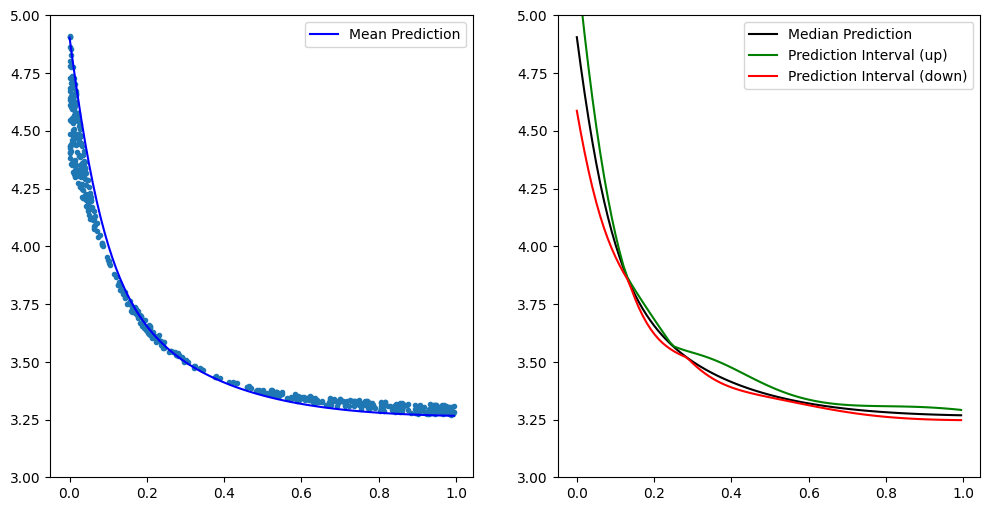

In [36]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Scatter plot of the original data points
ax1.plot(X, Y, ".")
ax1.plot(x_curve, y_mean, "b-", label="Mean Prediction")

# Plot the mean curve
# ax2.plot(x_curve, y_mean, "b-", label="Mean Prediction")
ax2.plot(x_curve, y_median, "k-", label="Median Prediction")

# Fill the area between the upper and lower prediction intervals with transparency
# ax2.fill_between(x_curve.flatten(), y_L_PI_array_train.flatten(), y_U_PI_array_train.flatten(), color='green', alpha=0.3, label="Prediction Interval")
ax2.plot(x_curve.flatten(), y_U_PI_array_train.flatten(), "g-", label="Prediction Interval (up)")
ax2.plot(x_curve.flatten(), y_L_PI_array_train.flatten(), "r-", label="Prediction Interval (down)")

ax1.set_ylim(3, 5)
ax2.set_ylim(3, 5)
ax1.legend()
ax2.legend()
plt.show()

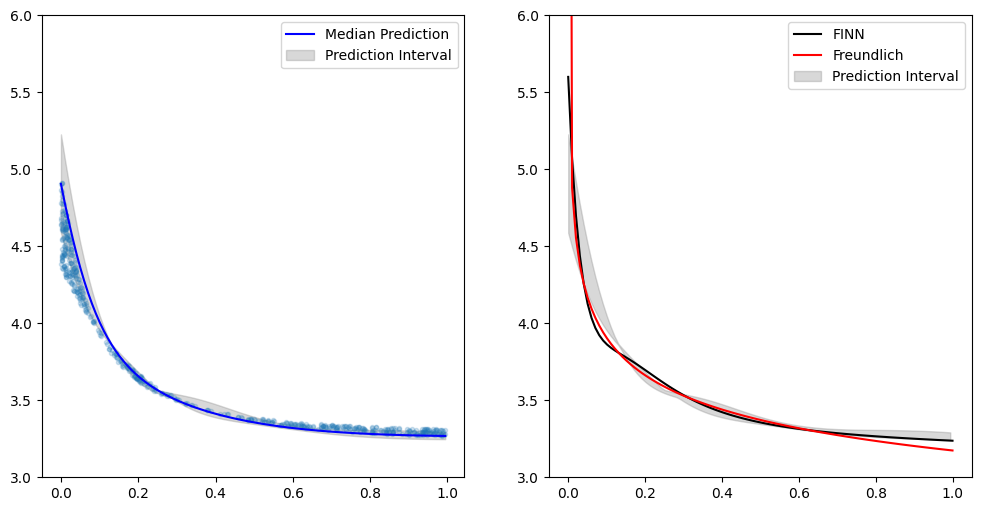

In [45]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# Scatter plot of the original data points
ax1.plot(X, Y, ".", alpha=0.2)

# Plot the mean curve
# ax1.plot(x_curve, y_mean, "b-", label="Mean Prediction")
ax1.plot(x_curve, y_median, "b-", label="Median Prediction")

# Plot additional curves
u_finn_ret = np.load("../data_out/default_finn/u_ret.npy")
finn_ret = np.load("../data_out/default_finn/predicted_retardations/retPred_100.npy")
ax2.plot(u_finn_ret, finn_ret, "k-", label="FINN")
ax2.plot(u_finn_ret, np.load("../data_out/default_finn/retardation_freundlich.npy"), "r-", label="Freundlich")

# Fill the area between the upper and lower prediction intervals with transparency
ax1.fill_between(x_curve.flatten(), y_L_PI_array_train.flatten(), y_U_PI_array_train.flatten(), color='grey', alpha=0.3, label="Prediction Interval")
ax2.fill_between(x_curve.flatten(), y_L_PI_array_train.flatten(), y_U_PI_array_train.flatten(), color='grey', alpha=0.3, label="Prediction Interval")

ax1.set_ylim(3, 6)
ax1.legend()
ax2.set_ylim(3, 6)
ax2.legend()
plt.show()

# Up-Down Training Data

In [38]:
data_train_up, data_train_down = create_PI_training_data(
    trainer.networks["mean"], X=trainer.x_train, Y=trainer.y_train
)
data_val_up, data_val_down = create_PI_training_data(
    trainer.networks["mean"], X=trainer.x_valid, Y=trainer.y_valid
)

In [39]:
type(xTrain)

torch.Tensor

In [40]:
from pathlib import Path
pup = Path("../data_out/tmp/3pinn_res_up.npy")
pdown = Path("../data_out/tmp/3pinn_res_down.npy")
pup.parent.mkdir(exist_ok=True, parents=True)
pdown.parent.mkdir(exist_ok=True, parents=True)
np.save(pup, data_train_up)
np.save(pdown, data_train_up)

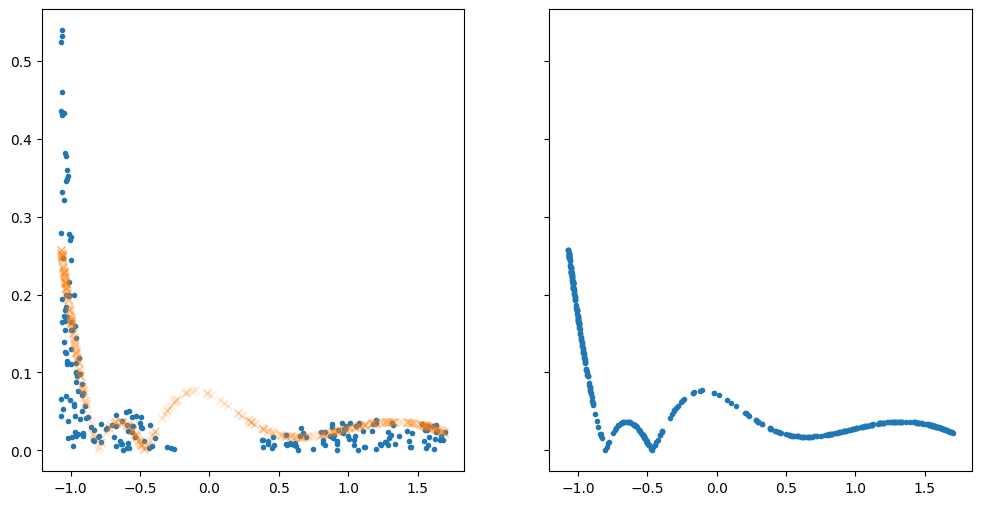

In [41]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
ax1.plot(*data_train_up, ".")
ax1.plot(xTrain.detach().numpy(), trainer.networks["up"](xTrain).detach().numpy(), "x", alpha=0.2)
ax2.plot(xTrain.detach().numpy(), trainer.networks["up"](xTrain).detach().numpy(), ".")
# plt.plot(*data_train_down, "x")
plt.show()

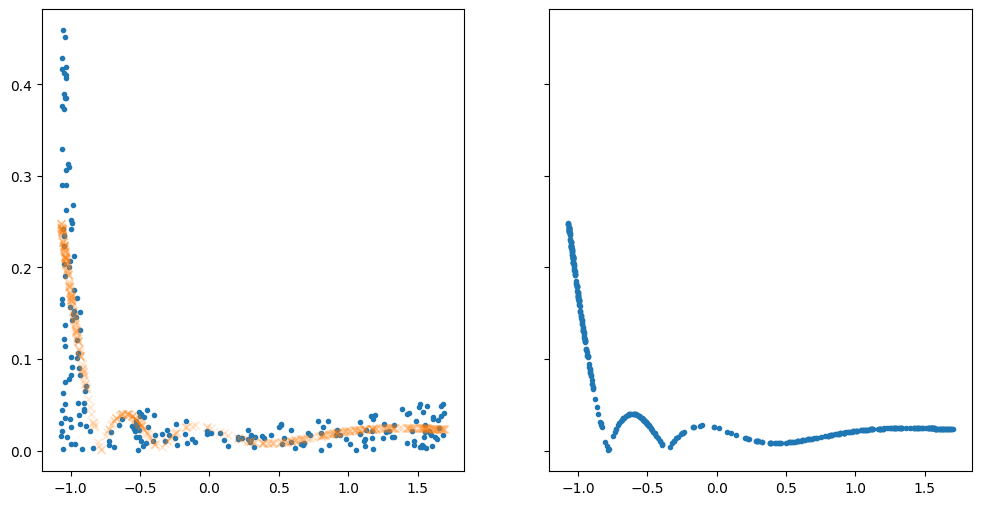

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
ax1.plot(*data_train_down, ".")
ax1.plot(xTrain.detach().numpy(), trainer.networks["down"](xTrain).detach().numpy(), "x", alpha=0.2)
ax2.plot(xTrain.detach().numpy(), trainer.networks["down"](xTrain).detach().numpy(), ".")
# plt.plot(*data_train_down, "x")
plt.show()